Problem Statment: To develop and train a deep learning model, BezierLaneNet, to predict Bézier curve control points from synthetic images of lane markings. The task involves:

    - Dataset Generation: Creating a SyntheticLaneDataset that generates synthetic images containing Bézier curves with randomly positioned control points.

    - Model Definition: Defining BezierLaneNet, which utilizes a ResNet-18 backbone pretrained on ImageNet. The model is adapted to regress the coordinates of Bézier curve control points from the input images.

    - Loss Function: Implementing bezier_curve_loss using Mean Squared Error (MSE) to measure the discrepancy between predicted and ground truth control points.

    - Training and Evaluation: Training the BezierLaneNet using synthetic data generated from SyntheticLaneDataset. The training process involves optimizing the model parameters using the Adam optimizer and evaluating model performance using the validation set.

    - Evaluation: Assessing the trained model's performance by calculating the average loss on a separate validation dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import random
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm

# Synthetic Dataset Generator
class SyntheticLaneDataset(Dataset):
    def __init__(self, num_images=1000, image_size=(360, 640), transform=None):
        self.num_images = num_images
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image, annotation = self.generate_image()
        if self.transform:
            image = self.transform(image)
        return image, annotation

    def generate_image(self):
        height, width = self.image_size
        image = np.zeros((height, width, 3), dtype=np.uint8)

        # Generate random control points for the Bézier curve
        control_points = np.array([
            [random.randint(0, width // 4), random.randint(height // 2, height)],
            [random.randint(width // 4, width // 2), random.randint(0, height // 2)],
            [random.randint(width // 2, 3 * width // 4), random.randint(0, height // 2)],
            [random.randint(3 * width // 4, width), random.randint(height // 2, height)]
        ])

        annotation = control_points.flatten()

        # Draw Bézier curve on the image
        curve = self.bezier_curve(control_points, n_points=100)
        for point in curve:
            cv2.circle(image, tuple(point), 1, (255, 255, 255), -1)

        return image, annotation

    def bezier_curve(self, points, n_points=100):
        t = np.linspace(0, 1, n_points)
        curve = np.zeros((n_points, 2))
        n = len(points) - 1
        for i in range(n + 1):
            curve += np.outer(self.bernstein(i, n, t), points[i])
        return curve.astype(int)

    def bernstein(self, i, n, t):
        return scipy.special.comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

# Define the Dataset
class LaneDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.annotations = os.listdir(annotation_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_name)
        if self.transform:
            image = self.transform(image)
        annot_name = os.path.join(self.annotation_dir, self.annotations[idx])
        annotation = np.loadtxt(annot_name, delimiter=',')
        return image, annotation

# Define the Model
class BezierLaneNet(nn.Module):
    def __init__(self, backbone='resnet18', num_control_points=4):
        super(BezierLaneNet, self).__init__()
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the final classification layer
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_control_points * 2)  # Each control point has an (x, y) coordinate
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x.view(-1, 4, 2)  # Reshape to (batch_size, num_control_points, 2)

# Define the Loss Function
def bezier_curve_loss(predicted, target):
    return nn.MSELoss()(predicted, target.float().view(predicted.size()))

# Training Function
def train_model(model, dataloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=loss.item())
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return model

# Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc='Evaluating', leave=False)
    with torch.no_grad():
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs)
            loss = bezier_curve_loss(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=loss.item())
    average_loss = total_loss / len(dataloader.dataset)
    print(f'Average Loss: {average_loss:.4f}')

# Hyperparameters
num_epochs = 25
learning_rate = 0.001
batch_size = 16

# Data Transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((360, 640)),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_dataset = SyntheticLaneDataset(num_images=1000, transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SyntheticLaneDataset(num_images=200, transform=data_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model, Criterion, and Optimizer
model = BezierLaneNet().to(device)
criterion = bezier_curve_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and Evaluate
model = train_model(model, train_dataloader, criterion, optimizer, num_epochs=num_epochs)
evaluate_model(model, val_dataloader)


/Users/dakshpatel/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dakshpatel/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Loss: 47957.8327


Epoch 2/25, Loss: 2702.7665


Epoch 3/25, Loss: 2202.6466


Epoch 4/25, Loss: 2168.5204


Epoch 5/25, Loss: 2166.7184


Epoch 6/25, Loss: 2201.7448


Epoch 7/25, Loss: 2145.0119


Epoch 8/25, Loss: 2003.1518


Epoch 9/25, Loss: 1894.9293


Epoch 10/25, Loss: 1873.6795


Epoch 11/25, Loss: 1750.4452


Epoch 12/25, Loss: 1542.6784


Epoch 13/25, Loss: 1388.2668


Epoch 14/25, Loss: 1307.2893


Epoch 15/25, Loss: 1263.7768


Epoch 16/25, Loss: 1159.2743


Epoch 17/25, Loss: 1065.1292


Epoch 18/25, Loss: 1038.7730


Epoch 19/25, Loss: 961.1682


Epoch 20/25, Loss: 865.1790


Epoch 21/25, Loss: 818.3476


Epoch 22/25, Loss: 783.8136


Epoch 23/25, Loss: 756.2729


Epoch 24/25, Loss: 710.5657


Epoch 25/25, Loss: 591.1238


Average Loss: 419.3735


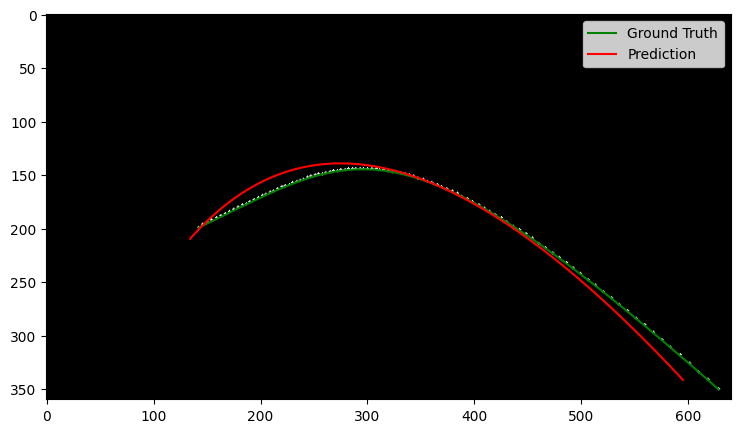

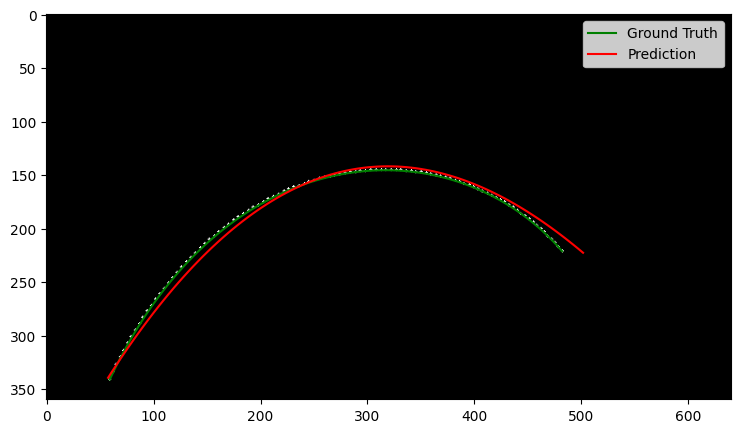

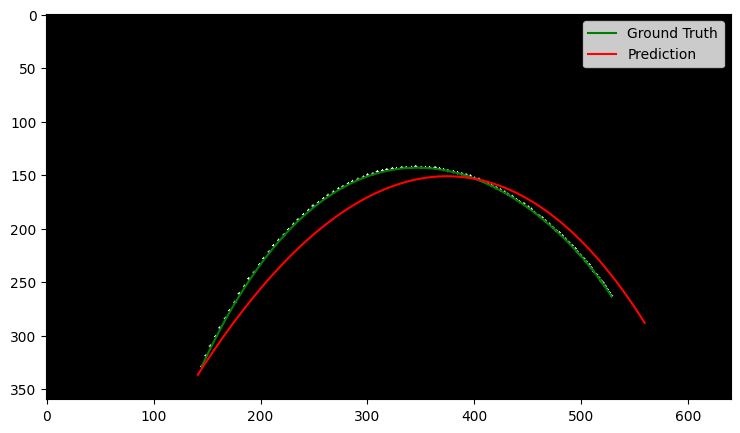

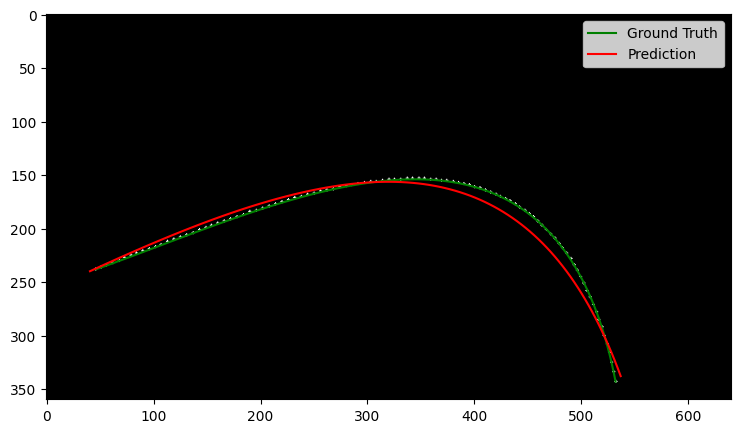

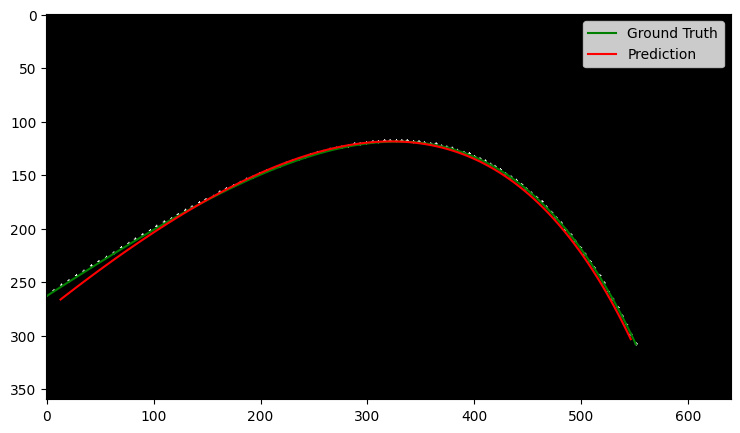

In [2]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, num_images=5):
    model.eval()
    images_plotted = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            for i in range(inputs.shape[0]):
                if images_plotted >= num_images:
                    return
                fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                img = inputs[i].transpose(1, 2, 0)
                ax.imshow(img)

                # Plot ground truth Bezier curve
                gt_points = targets[i].reshape(-1, 2)
                gt_curve = bezier_curve(gt_points)
                ax.plot(gt_curve[:, 0], gt_curve[:, 1], 'g-', label='Ground Truth')

                # Plot predicted Bezier curve
                pred_points = outputs[i].reshape(-1, 2)
                pred_curve = bezier_curve(pred_points)
                ax.plot(pred_curve[:, 0], pred_curve[:, 1], 'r-', label='Prediction')

                ax.legend()
                plt.show()
                images_plotted += 1

def bezier_curve(points, n_points=100):
    t = np.linspace(0, 1, n_points)
    curve = np.zeros((n_points, 2))
    n = len(points) - 1
    for i in range(n + 1):
        curve += np.outer(bernstein(i, n, t), points[i])
    return curve

def bernstein(i, n, t):
    return scipy.special.comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

# Usage
plot_predictions(model, val_dataloader, num_images=5)
